# `nbragg` tutorial
Tsviki Y. Hirsh, Andrew FT. Leong

Nov 11th 2024

This tutorial demonstrates the usage of nbragg to model and fit Bragg-Edges transmission spectrum of an iron powder.

The nbragg repo is located here: [https://github.com/TsvikiHirsh/nbragg](https://github.com/TsvikiHirsh/nbragg)

# Installation
Simply type

```bash
pip install git+https://github.com/TsvikiHirsh/nbragg.git
```

In [1]:
import nbragg

# Quick start

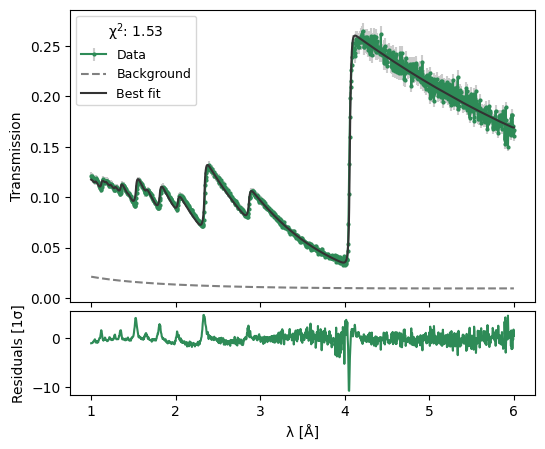

In [2]:
data = nbragg.Data.from_transmission("iron_powder_transmission.csv")            # read data
xs = nbragg.CrossSection(iron="Fe_sg229_Iron-alpha.ncmat")                      # define sample
model = nbragg.TransmissionModel(xs,vary_background=True,vary_response=True)    # define model
result = model.fit(data)                                                        # perform fit
result.plot();                                                                  # plot results

In [46]:
result.params

name,value,standard error,relative error,initial value,min,max,vary
thickness,1.97199071,0.02039826,(1.03%),1.0,0.00000000,5.00000000,True
norm,0.78300297,0.00980447,(1.25%),1.0,0.10000000,10.0000000,True
temp,300.000000,0.00000000,(0.00%),300.0,77.0000000,1000.00000,False
α1,2.58187465,0.06907095,(2.68%),3.67,1.0000e-03,5.00000000,True
β1,3.82821872,0.12717650,(3.32%),3.06,1.0000e-03,5.00000000,True
b0,-0.02214307,0.00722539,(32.63%),0.0,-1000000.00,1000000.00,True
b1,0.00684791,0.00222812,(32.54%),0.0,-1000000.00,1000000.00,True
b2,0.03639766,0.00512435,(14.08%),0.0,-1000000.00,1000000.00,True


# Load data
Use the `nbragg.Data` object to read bragg edge data

In [47]:
data = nbragg.Data.from_transmission("iron_powder_transmission.csv")

The data is accessible as a table using `nbragg.Data.table`. An automatic plot is generated using the `nbragg.Data.plot` method.

In [48]:
data.table

,wavelength,trans,err
0,0.501098,0.148315,0.004449
1,0.505493,0.147728,0.004432
2,0.509889,0.147725,0.004432
3,0.514284,0.148043,0.004441
4,0.518680,0.148369,0.004451
...,...,...,...
2156,9.977258,0.050633,0.001519
2157,9.982328,0.043011,0.001291
2158,9.986135,0.103448,0.003104
2159,9.991219,0.062500,0.001875


<Axes: xlabel='wavelength [Å]', ylabel='Transmission'>

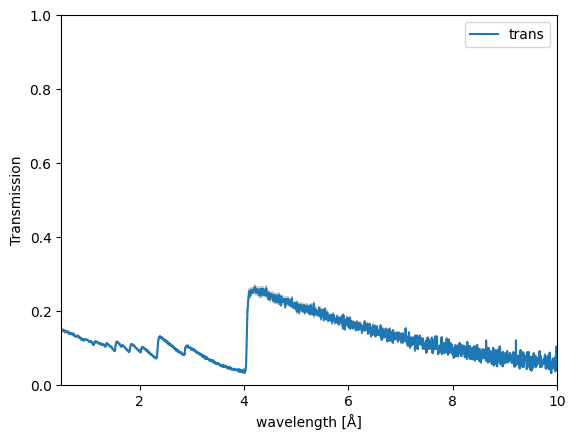

In [49]:
data.plot()

## Define samples
In this step the user defines the composition of the sample. You can choose from a variety of predefined crystalline materials from the `ncrystal` standard library, that is available under the `nbragg.materials` dictionary.

In [50]:
nbragg.materials["AgBr_sg225_SilverBromide.ncmat"]

{'name': 'SilverBromide',
 'mat': 'AgBr_sg225_SilverBromide.ncmat',
 'formula': 'AgBr',
 'space_group': 'sg225'}

Use the `nbragg.CrossSection method to upload a single material from the standard library

In [51]:
gamma = nbragg.CrossSection(gamma=nbragg.materials["Fe_sg225_Iron-gamma.ncmat"])
alpha = nbragg.CrossSection(alpha=nbragg.materials["Fe_sg229_Iron-alpha.ncmat"])

You can also register new `.ncmat` files into the ncrystal library using the `nbragg.utils.register_material` and upload them in the same way.

In [52]:
nbragg.utils.register_material("Fe_sg229_Iron-alpha_LGS.ncmat")
alphaLGS = nbragg.CrossSection(alpha=nbragg.materials["Fe_sg229_Iron-alpha_LGS.ncmat"])

You can easily combine materials simply by adding them together. Check the ncrystal cfg_string that uses the phases keyword to define a multiphase material

In [53]:
xs = alpha + gamma

# or

xs = alpha*0.3 + gamma*0.7

In [54]:
xs.cfg_string

'phases<0.3*Fe_sg229_Iron-alpha.ncmat;temp=300K&0.7*Fe_sg225_Iron-gamma.ncmat;temp=300K>'

The cross section data can be accessed through `nbragg.CrossSection.table` and plotted using the `nbragg.CrossSection.plot` method

In [55]:
xs.table

,alpha,gamma,total
wavelength,,,
1.00,12.295385,12.428371,12.387429
1.01,12.416298,12.511480,12.482177
1.02,12.417513,12.444117,12.435927
1.03,12.541085,12.208773,12.311080
1.04,12.666988,12.289012,12.405378
...,...,...,...
9.95,15.322888,15.548666,15.479157
9.96,15.337758,15.563652,15.494108
9.97,15.352626,15.578636,15.509056


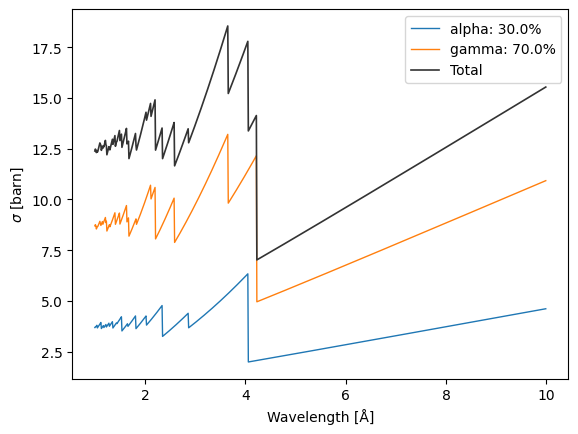

In [56]:
xs.plot();

# Define a transmission model
Next step is to define a model and adjust model parameters. The fit process in nbragg is based the super friendly package `lmfit`.

Defining a transmission model requires providing the `nbragg.CrossSection` object you created, as well as few flags in case you are interested in including non-default parameters to the model. In this example we define a model and request to vary background and response parameters.

In [57]:
model = nbragg.TransmissionModel(alpha,background="polynomial3",vary_background=True,vary_response=True,vary_tof=True)

In [58]:
model.params

name,value,initial value,min,max,vary
thickness,1.00000000,1.0,0.00000000,5.00000000,True
norm,1.00000000,1.0,0.10000000,10.0000000,True
temp,300.000000,300.0,77.0000000,1000.00000,False
L0,1.00000000,1.0,0.50000000,1.50000000,True
t0,0.00000000,0.0,-5.0000e-06,5000000.00,True
α1,3.67000000,3.67,1.0000e-03,5.00000000,True
β1,3.06000000,3.06,1.0000e-03,5.00000000,True
b0,0.00000000,0.0,-1000000.00,1000000.00,True
b1,0.00000000,0.0,-1000000.00,1000000.00,True
b2,0.00000000,0.0,-1000000.00,1000000.00,True


# Fit
After adjusting your model params, fit is done simply by calling `model.fit`

In [59]:
result = model.fit(data,wlmin=1,wlmax=5)

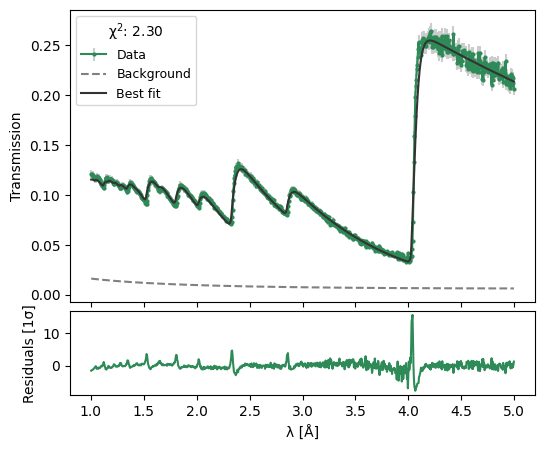

In [60]:
result.plot();

In [61]:
result

# Oriented materials

You can also use nbragg to load oriented materials, this requires specifing the orientation of the crystal in respect to the beam (z-axis) with `dir1` key name, and the orientation in respect to the y-axis with the `dir2` key. After fixing an orientation, you can also specify two angles, `theta` and `phi` that represent rotations around z and y axis accordinglly. 

The mosaicity of each phase can be specified using the `mos` keyword.

This is an example to a multiphase oriented material

In [62]:
nbragg.materials["Be_sg194.ncmat"]

{'name': 'Be',
 'mat': 'Be_sg194.ncmat',
 'formula': 'Be',
 'space_group': 'sg194'}

In [63]:
gamma =     {
            "mat": "Fe_sg225_Iron-gamma.ncmat",
            "temp": 300,
            "weight": 0.3
            }
beryllium = {
            "mat": "Be_sg194.ncmat",
            "temp": 300,
            "mos": 3,
            "dir1":[0,0,1],
            "dir2":[1,0,0],
            "theta":10,
            "phi":10.,
            "weight": 0.7,
            "dirtol":5
            }
xs2 = nbragg.CrossSection(gamma=gamma,beryllium=beryllium)

In [64]:
xs2.materials

{'gamma': {'mat': 'Fe_sg225_Iron-gamma.ncmat',
  'temp': 300,
  'mos': None,
  'dir1': None,
  'dir2': None,
  'dirtol': None,
  'theta': None,
  'phi': None,
  'weight': 0.3},
 'beryllium': {'mat': 'Be_sg194.ncmat',
  'temp': 300,
  'mos': 3,
  'dir1': [0, 0, 1],
  'dir2': [1, 0, 0],
  'dirtol': 5,
  'theta': 10,
  'phi': 10.0,
  'weight': 0.7}}

The config string is updated accordinglly

In [65]:
xs2.cfg_string

'phases<0.3*Fe_sg225_Iron-gamma.ncmat;temp=300K&0.7*Be_sg194.ncmat;temp=300K;mos=3deg;dirtol=5deg;dir1=@crys_hkl:0.9848,0.0000,0.1736@lab:0,0,1;dir2=@crys_hkl:-0.1710,0.1736,0.9698@lab:0,1,0>'

<Axes: xlabel='Wavelength [Å]', ylabel='$\\sigma$ [barn]'>

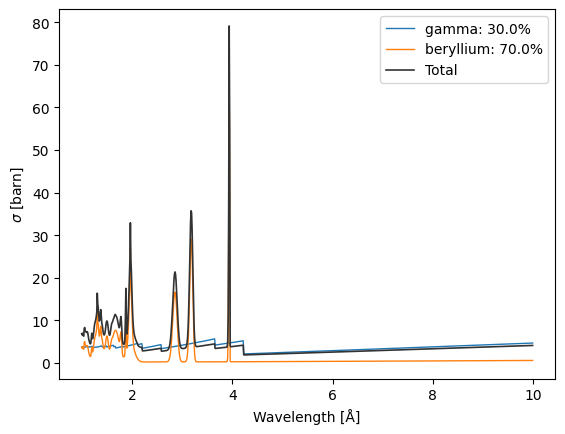

In [66]:
xs2.plot()

Oriented materials can now be combined using the same methods as before

In [67]:
xs3 = xs2*0.2 + xs*0.8

In [68]:
xs3.phases

{'gamma': 'Fe_sg225_Iron-gamma.ncmat;temp=300K',
 'beryllium': 'Be_sg194.ncmat;temp=300K;mos=3deg;dirtol=5deg;dir1=@crys_hkl:0.9848,0.0000,0.1736@lab:0,0,1;dir2=@crys_hkl:-0.1710,0.1736,0.9698@lab:0,1,0',
 'alpha': 'Fe_sg229_Iron-alpha.ncmat;temp=300K',
 'gamma_1': 'Fe_sg225_Iron-gamma.ncmat;temp=300K'}

<Axes: xlabel='Wavelength [Å]', ylabel='$\\sigma$ [barn]'>

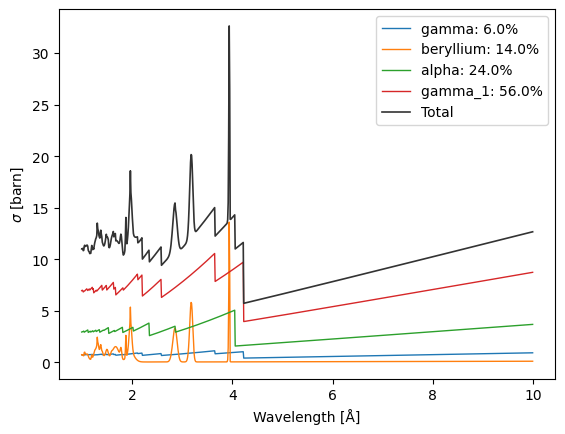

In [69]:
xs3.plot()

There are special methods to convert MAUD XZX orientation format to material dictionary that can be read by `nbragg`

In [2]:
xs = nbragg.CrossSection(gamma=nbragg.materials["Fe_sg225_Iron-gamma.ncmat"])

In [3]:
maud_strings = ["Vol:0.25, EA_ZXZ:(86.14 37.54 307.74), x||(11 -7 10), y||(8 12 -1), z||(-6 5 10)",
                "Vol:0.16, EA_ZXZ:(302.43 4.41 28.67), x||(11 6 -1), y||(-6 11 -1), z||(-1.109336e-32 1 12)",
                "Vol:0.07, EA_ZXZ:(255.01 17.18 62.94), x||(12 11 -5), y||(-8 9 1), z||(2 1 7)",
                "Vol:0.04, EA_ZXZ:(170.22 12.43 205.93), x||(10 -3 0), y||(3 10 2), z||(-1 -2 10)"]

xs.from_maud(maud_line=maud_strings[1],dirtol=5).materials

{'gamma': {'mat': 'Fe_sg225_Iron-gamma.ncmat',
  'temp': 300.0,
  'mos': None,
  'dir1': [-0.079555728417573, 0.47733437050543803, 0.875113012593303],
  'dir2': [-0.079555728417573, 0.875113012593303, -0.47733437050543803],
  'dirtol': 5.0,
  'theta': None,
  'phi': None,
  'weight': 0.16}}

# Fitting Large-Grain Steel Data



Now we can set this way four different phases of gamma-Iron (and a powder phase)

In [4]:
xs = nbragg.CrossSection(γ=nbragg.materials["Fe_sg225_Iron-gamma_LGS.ncmat"])
mats = xs.materials.copy() # keep this for powder phase

for i,maud_string in enumerate(maud_strings):
    gamma_iron = xs.from_maud(maud_string,dirtol=3,mos=15,suffix=i+1)
    mats.update(gamma_iron.materials)

gamma_iron = nbragg.CrossSection(mats)

In [5]:
gamma_iron.materials

{'γ': {'mat': 'Fe_sg225_Iron-gamma_LGS.ncmat',
  'temp': 300.0,
  'mos': None,
  'dir1': None,
  'dir2': None,
  'dirtol': None,
  'theta': None,
  'phi': None,
  'weight': 0.6578947368421053},
 'γ1': {'mat': 'Fe_sg225_Iron-gamma_LGS.ncmat',
  'temp': 300.0,
  'mos': 15.0,
  'dir1': [0.6085806194501846, -0.42600643361512924, 0.669438681395203],
  'dir2': [-0.06917144638660747, 0.8300573566392896, 0.5533715710928597],
  'dirtol': 3.0,
  'theta': None,
  'phi': None,
  'weight': 0.16447368421052633},
 'γ2': {'mat': 'Fe_sg225_Iron-gamma_LGS.ncmat',
  'temp': 300.0,
  'mos': 15.0,
  'dir1': [-0.079555728417573, 0.47733437050543803, 0.875113012593303],
  'dir2': [-0.079555728417573, 0.875113012593303, -0.47733437050543803],
  'dirtol': 3.0,
  'theta': None,
  'phi': None,
  'weight': 0.10526315789473684},
 'γ3': {'mat': 'Fe_sg225_Iron-gamma_LGS.ncmat',
  'temp': 300.0,
  'mos': 15.0,
  'dir1': [-0.29361010975735174, 0.6459422414661737, 0.7046642634176441],
  'dir2': [0.0827605888602368, 0.7

<Axes: xlabel='Wavelength [Å]', ylabel='$\\sigma$ [barn]'>

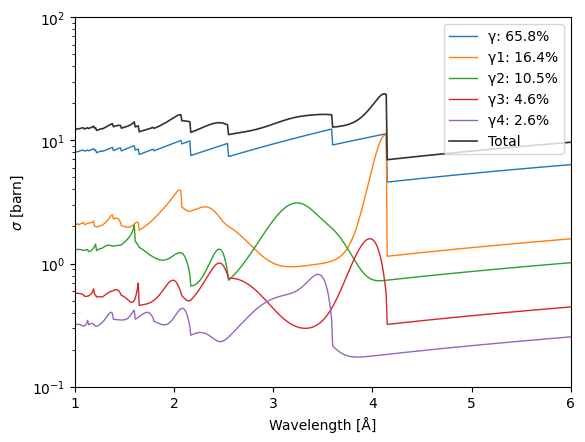

In [6]:
gamma_iron.plot(logy=True,xlim=(1,6),ylim=(1e-1,1e2))

## Load data
In this section, we will load and fit data for a large-grain steel sample. To do this, we use the `nbragg.Data.from_counts` method, which requires two CSV files: one containing the signal measurements and the other containing the open-beam measurements.

Each CSV file should contain three columns:
- **slice number**: Identifier for each slice of the sample.
- **counts**: Measured counts for each slice.
- **error**: Measurement error associated with each count value.


In [7]:
data = nbragg.Data.from_counts("large_grain_steel_0deg.csv","openbeam.csv",sys_err=0.01)

<Axes: xlabel='wavelength [Å]', ylabel='Transmission'>

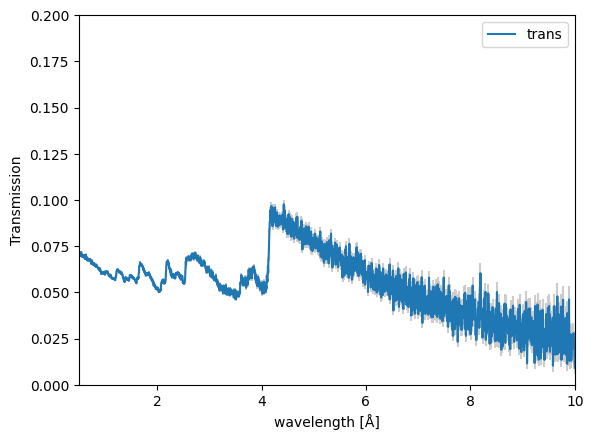

In [8]:
data.plot(ylim=(0,0.2))

We now define a model based on the gamma_iron cross section definition

In [9]:
model = nbragg.TransmissionModel(gamma_iron,vary_background=True,vary_weights=True,)

In [10]:
model.params["norm"].value = 1./2.3
model.params["thickness"].value = 1.27
model.params["thickness"].vary = True
model.params

name,value,initial value,min,max,vary,expression
thickness,1.27000000,1.0,0.00000000,5.00000000,True,
norm,0.43478261,1.0,0.10000000,10.0000000,True,
temp,300.000000,300.0,77.0000000,1000.00000,False,
p1,3.21887582,3.218875824868201,-14.0000000,14.0000000,True,
p2,1.83258146,1.8325814637483102,-14.0000000,14.0000000,True,
p3,1.38629436,1.3862943611198906,-14.0000000,14.0000000,True,
p4,0.55961579,0.5596157879354228,-14.0000000,14.0000000,True,
γ,0.65789474,None,-inf,inf,False,exp(p1) / (1 + exp(p1) + exp(p2) + exp(p3) + exp(p4))
γ1,0.16447368,None,-inf,inf,False,exp(p2) / (1 + exp(p1) + exp(p2) + exp(p3) + exp(p4))
γ2,0.10526316,None,-inf,inf,False,exp(p3) / (1 + exp(p1) + exp(p2) + exp(p3) + exp(p4))


In [11]:
result = model.fit(data,wlmin=2,wlmax=5)

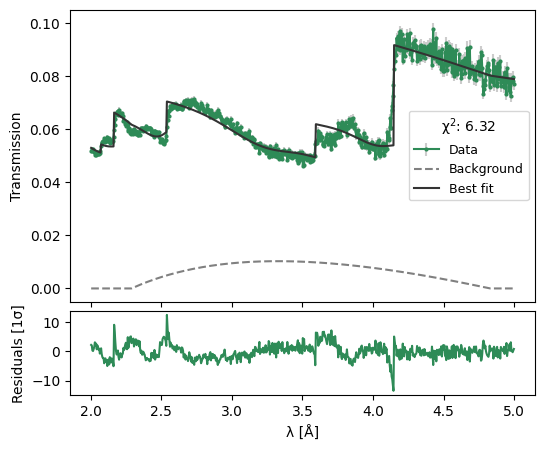

In [12]:
result.plot();

In [13]:
result

Now we try vary the orientation as well

In [14]:
model = nbragg.TransmissionModel(gamma_iron,vary_background=True,vary_weights=True,vary_orientation=True)
model.update_params(result.params)

In [15]:

model.params["thickness"].vary = False
model.params["norm"].vary = False
model.params["θ2"].vary = False
model.params["θ3"].vary = False
model.params["θ4"].vary = False
model.params["θ5"].vary = False
model.params["ϕ2"].vary = False
model.params["ϕ3"].vary = False
model.params["ϕ4"].vary = False
model.params["ϕ5"].vary = False
model.params

name,value,initial value,min,max,vary
thickness,0.77590493,0.7759049277598227,0.00000000,5.00000000,False
norm,0.13624363,0.1362436311953851,0.10000000,10.0000000,False
temp,300.000000,300.0,77.0000000,1000.00000,False
p1,13.4795820,13.479581993608765,-14.0000000,14.0000000,True
p2,-0.34891662,-0.34891661629082193,-14.0000000,14.0000000,True
p3,11.5195422,11.519542165417988,-14.0000000,14.0000000,True
p4,10.5177719,10.517771948007116,-14.0000000,14.0000000,True
γ,0.83851789,0.8385178861838724,-inf,inf,False
γ1,8.2770e-07,8.276975917081358e-07,-inf,inf,False
γ2,0.11810760,0.11810760125616042,-inf,inf,False


In [16]:
result2 = model.fit(data,wlmin=2,wlmax=5)

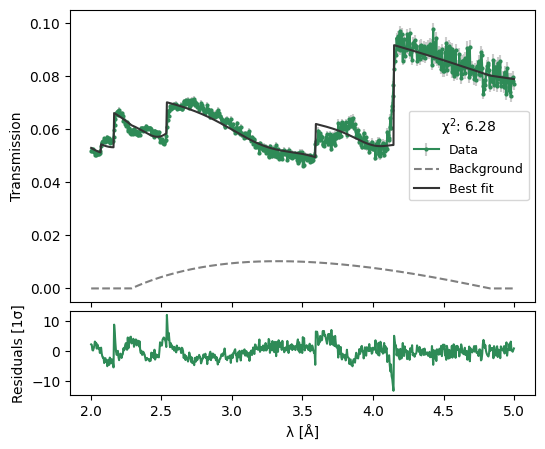

In [17]:
result2.plot();